# Testing area for MFTM 

# Conversion using Trimesh

In [9]:
import trimesh
import numpy as np

def save_glb_to_xyz(glb_path, xyz_path):
    # Load the mesh
    mesh = trimesh.load(glb_path)
    # Extract vertex data

    # Prepare the XYZ format data
    with open(xyz_path, 'w') as xyz_file:
        for geom in mesh.geometry.values():
            # For each mesh, write its vertices to the XYZ file
            for vertex in geom.vertices:
                xyz_file.write(f"{vertex[0]} {vertex[1]} {vertex[2]}\n")


    print(f"XYZ file saved to {xyz_path}")


# Example usage
usdz_path = 'secondFloor.usdz'
glb_path = 'Room.glb'
xyz_path = 'testing.xyz'

# Convert the USDZ file to GLB
os.system(f'usd2gltf -i "{usdz_path}" -o "{glb_path}"')




save_glb_to_xyz(glb_path, xyz_path)


Converting: secondFloor.usdz
To: Room.glb
Converted!
XYZ file saved to testing.xyz


In [10]:
def glb_to_xyz(glb_path, xyz_path):
    # Load the GLB file
    mesh = trimesh.load_mesh(glb_path)
    
    # Ensure we're working with a unified mesh in case the GLB contains multiple meshes
    if isinstance(mesh, trimesh.Scene):
        mesh = mesh.dump(concatenate=True)
    
    # Extract vertices
    vertices = mesh.vertices
    
    # Write vertices to XYZ file
    with open(xyz_path, 'w') as f:
        for vertex in vertices:
            f.write(f'{vertex[0]} {vertex[1]} {vertex[2]}\n')

# Specify the paths to your GLB file and the output XYZ file
glb_path = 'Room.glb'
xyz_path = 'file.xyz'

# Convert GLB to XYZ
os.system(f'usd2gltf -i "{usdz_path}" -o "{glb_path}"')
glb_to_xyz(glb_path, xyz_path)

Converting: secondFloor.usdz
To: Room.glb


Converted!


# Print outpout of the conversion of a 3D model to a 3D mesh using Trimesh

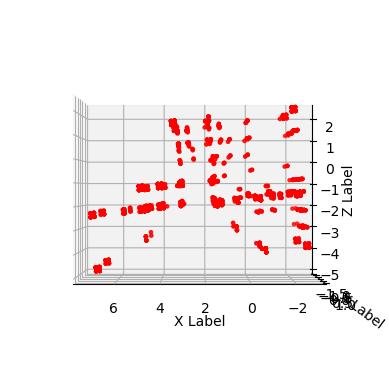

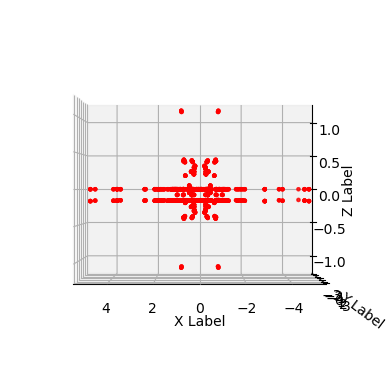

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to read XYZ file and return coordinates
def read_xyz_file(filepath):
    x, y, z = [], [], []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.split()  # Split by whitespace
            if len(parts) == 3:  # Ensure there are exactly three components
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                    z.append(float(parts[2]))
                except ValueError:  # In case the conversion to float fails
                    print("Could not convert data to float.")
    return x, y, z

# Function to plot the points in 3D
def plot_3d_points(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x, y, z, c='r', s=5)  # Plot points in red color with circle markers

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.view_init(elev=0, azim=90)

    plt.show()

# Assuming the XYZ data is saved in 'data.xyz' in the current directory
xyz_filepath = 'file.xyz'

# Read the XYZ file to get coordinates
x, y, z = read_xyz_file(xyz_filepath)

# Plot the points
plot_3d_points(x, y, z)


xyz_filepath = 'testing.xyz'
x,y,z = read_xyz_file(xyz_filepath)
plot_3d_points(x, y, z)

# Conversion using existing Library Apose3D

In [12]:
import aspose.threed as a3d
import os


license = a3d.License()
license.set_license("Aspose.3D.lic")
filename = os.path.join('Room.usdz')
outputname = os.path.join('testing1.xyz')
os.system('usd2gltf -i ' + filename + ' -o /var/www/api/scripts/Room.glb')
scene = a3d.Scene.from_file("/var/www/api/scripts/Room.glb")
scene.save(outputname)


ModuleNotFoundError: No module named 'aspose'

# Print out the result of the conversion w/ aspose

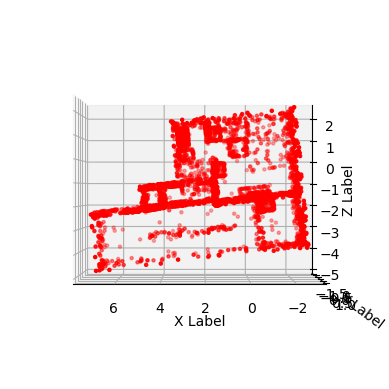

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to read XYZ file and return coordinates
def read_xyz_file(filepath):
    x, y, z = [], [], []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.split()  # Split by whitespace
            if len(parts) == 3:  # Ensure there are exactly three components
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                    z.append(float(parts[2]))
                except ValueError:  # In case the conversion to float fails
                    print("Could not convert data to float.")
    return x, y, z

# Function to plot the points in 3D
def plot_3d_points(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x, y, z, c='r', s=5)  # Plot points in red color with circle markers

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.view_init(elev=0, azim=90)

    plt.show()

# Assuming the XYZ data is saved in 'data.xyz' in the current directory
xyz_filepath = 'oldUser.xyz'

# Read the XYZ file to get coordinates
x, y, z = read_xyz_file(xyz_filepath)

# Plot the points
plot_3d_points(x, y, z)

# backend.py   

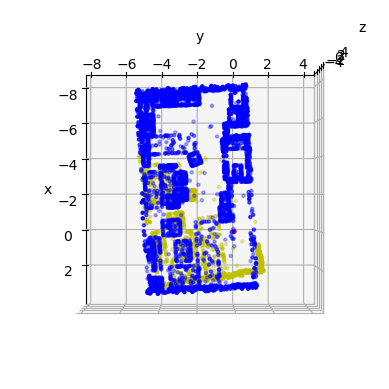

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
import math
import scipy
import random
import pygltflib as pygltf
from plyfile import PlyData, PlyElement
import open3d as o3d
import os
import mpl_toolkits.mplot3d.art3d as art3d

#ignore warnings
pd.set_option('mode.chained_assignment', None)

UPLOAD_FOLDER = '1f_facing_N/sameSpotSouth/'
BLUEPRINT_FOLDER = '1f_facing_N/'
#This is where the poind cloud is read into
# if you want to test using my files update to either SecondFloorScan.xyz or firstFloor.xyz
# blueprintfile = os.path.join(UPLOAD_FOLDER, 'SecondFloorScan.xyz')
blueprintfile = os.path.join(BLUEPRINT_FOLDER, 'firstFloorSouth.xyz')
blueprint = pd.read_csv(blueprintfile, header=None, delimiter=' ',skiprows=[0])
#blueprint = pd.read_csv("/content/point_cloud__meters.xyz", header=None, delimiter=' ',)


#this is the users environment
userfile = os.path.join(UPLOAD_FOLDER, 'userEnvironment.xyz')
little = pd.read_csv(userfile, header=None, delimiter=' ',skiprows=[0])


#scale down dataframe if needed
#blueprint = blueprint / 10


#for some reason, "x" values get scanned in backwards from usdz files, this reverses it. When we use a real blueprint, this should not be nessecary
blueprint[0] = blueprint[0] * -1

little[0] = little[0] * -1


#index how much we had to shift user environment point cloud in order to put it back later
littleShiftInX = little[1].min()

littleShiftInY = little[0].min()

littleShiftInZ = little[2].min()


#rotate blueprint if nessecary
angle_deg = 0

yaw_angle_rad = np.radians(angle_deg)


rotation_matrix = np.array([
    [np.cos(yaw_angle_rad), 0, np.sin(yaw_angle_rad)],
    [0, 1, 0],
    [-np.sin(yaw_angle_rad), 0, np.cos(yaw_angle_rad)]
])





tempnp = np.dot(blueprint, rotation_matrix)

blueprint = pd.DataFrame(tempnp)









#function to bring dataframe to (0,0)
def bringToCenter(dataframe):

  dataframe.loc[:, 1] = dataframe[1] - dataframe[1].min()

  dataframe.loc[:, 0] = dataframe[0] - dataframe[0].min()

  dataframe.loc[:, 2] = dataframe[2] - dataframe[2].min()




#bring dataframes to (0,0)
bringToCenter(blueprint)
bringToCenter(little)

#set up plot
fig=plt.figure()
ax=Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')
axis = 10
# ax.set_xlim3d(0,axis)
# ax.set_ylim3d(0,axis)
# ax.set_zlim3d(0,axis)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')



#read in x y z of blueprint
xn = blueprint[0]
yn = blueprint[2]
zn = blueprint[1]



#each node contains a dataframe that is a subsection of the blueprint
#value for indexing purposes and each node indexes how much each subsection has to move in
#the x y and z to get to (0,0), this is important to move entire blueprint later
class Node:
    # Constructor to create a new node
    def __init__(self, df):
        self.df = df
        self.value = None
        self.shiftInX = df[1].min()

        self.shiftInY = df[0].min()

        self.shiftInZ = df[2].min()

#function that takes user environment and blueprint as arguments, divides blueprint into subsections, each as big as the user environment
# Every half meter in the x and y, a new subsection is created, therefore the subsections overlap each other.
#it returns a list of subsection dataframes
def buildSubsectionList(littleDF,dataframe):
  maxx = math.ceil(dataframe[0].max())

  maxy = math.ceil(dataframe[2].max())

  littlex = math.ceil(littleDF[0].max())

  littley = math.ceil(littleDF[2].max())

  dataframes = []

  i = 0
  increment = 0.5
  while i < maxx:
      j = 0

      while j < maxy:
          i_df = dataframe[(dataframe[0] < i + littlex) & (dataframe[0] > i) & (dataframe[2] < j + littley) & (dataframe[2] > j)]
          dataframes.append(i_df)

          j += increment

      i += increment


  return dataframes

#create subsection list of blueprint
dflist = buildSubsectionList(little,blueprint)


#turn subsections of buildings into nodes and add them to nodes list, bring each subsection to center and return list of nodes
nodes = []
for i in range(len(dflist)):
  temp = Node(dflist[i])
  temp.val = i
  bringToCenter(temp.df)
  nodes.append(temp)



#takes in user environment and list of subsection nodes as argument. does a linear search through the node list, measuring hausdorff from user
#environment to subsection, and returns the index of node list that gives the smallest value
def findLocation(littleDF,nodeList):
  firstResult = scipy.spatial.distance.directed_hausdorff(littleDF, nodeList[0].df, seed=0)
  bestHausdorff = firstResult[0]
  retval = 0

  for i in range(len(nodeList)):
    result = scipy.spatial.distance.directed_hausdorff(littleDF, nodeList[i].df, seed=0)
    current_hausdorff = result[0]

    if (current_hausdorff < bestHausdorff):
      bestHausdorff = current_hausdorff
      retval = i
  return retval







#find index of node list that is most similar to user environment
result = findLocation(little,nodes)


#move user environment back to its original spot
little.loc[:, 1] = little[1] + littleShiftInX

little.loc[:, 0] = little[0] + littleShiftInY

little.loc[:, 2] = little[2] + littleShiftInZ

#this block of code moves the entire blueprint such that the subsection that best matches the users
#environment is moved to  right where the user is, this final location of the blueprint dataframe is what we will send
#to the user so they can visualize where in the buiding they are
blueprint.loc[:, 1] = blueprint[1] - nodes[result].shiftInX

blueprint.loc[:, 0] = blueprint[0] - nodes[result].shiftInY

blueprint.loc[:, 2] = blueprint[2] - nodes[result].shiftInZ


blueprint.loc[:, 1] = blueprint[1] + littleShiftInX

blueprint.loc[:, 0] = blueprint[0] + littleShiftInY

blueprint.loc[:, 2] = blueprint[2] + littleShiftInZ




#load in user environment xyz
tx = little[0]
ty = little[2]
tz = little[1]


#load in subsection that was a best fit for user environment and display it if you want
resultx = nodes[result].df[0]
resulty = nodes[result].df[2]


# ax.scatter(resultx,resulty,color="r",s=5)

#load in final result of blueprint in blue
ax.scatter(xn,yn,zn,color="b",s=5)

#load in user environment in yellow
ax.scatter(tx,ty,tz,color="y",s=5)


#show results from birds eye view
ax.view_init(elev=90, azim=0)
circle = plt.Circle((0, 0), 0.1, color='r')
ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(circle, z=0, zdir='z')
ax.axis("equal")
downloadfile = os.path.join('export.png')
plt.show()


#plot results
#plt.show()


#prepare blue print for exporting
df = blueprint
#reverse the x dimension again since this is how the front end likes it
df[0] = df[0] * -1

# point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(df[[0, 2, 1]].values)

# # Save the point cloud as a PLY file
# o3d.io.write_point_cloud('export.ply', point_cloud)

#point_cloud = o3d.geometry.PointCloud()
#point_cloud.points = o3d.utility.Vector3dVector(df[[0, 1, 2]].values)

# Save the point cloud as an ASCII PLY file
# o3d.io.write_point_cloud('exportascii.ply', point_cloud, write_ascii=True)


# Backend2

In [13]:
#prepare blue print for exporting
df = blueprint
#reverse the x dimension again since this is how the front end likes it
df[0] = df[0] * -1

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(df[[0, 2, 1]].values)

# # Save the point cloud as a PLY file
#o3d.io.write_point_cloud('export.ply', point_cloud)

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(df[[0, 1, 2]].values)

#Save the point cloud as an ASCII PLY file
downloadname = os.path.join('export.ply')
o3d.io.write_point_cloud(downloadname, point_cloud, write_ascii=True)


True